Install necessary libraries `scipy` for scientific computing, `seaborn` for data visualization capabilities, and `optuna` for hyperparameter tuning.


In [ ]:
# Install Required Libraries
!pip install scipy seaborn optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00


"Mount Google Drive to access the data

In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the required libraries. `numpy` for numerical operations, `scipy.io` for loading MATLAB files, `sklearn` for machine learning model creation, training, and evaluation, `matplotlib.pyplot` and `seaborn` for data visualization, and `optuna` for hyperparameter tuning


In [ ]:
# Import necessary libraries
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

Load the coherence data from a MATLAB (.mat) file stored in Google Drive. It contains the coherence matrices for Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC). Use `scipy.io.loadmat` to read the .mat file


In [ ]:
# Load the coherence data from .mat file
mat_file_path = '/content/drive/MyDrive/GNN_Approach/Data_files/Coherence.mat'
mat = scipy.io.loadmat(mat_file_path)
coherence_data = mat['Coherence'][0, 0]

Extract the Coherence data for different categories: Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD)

In [ ]:
# Extracting data in different categories (AZ, FTD, HC)
coherence_AZ_F = coherence_data['AZ']
coherence_HC_F = coherence_data['HC']

Extract the data corresponding to the 3rd frequency band (index 2) and then reshape the extracted data

In [ ]:
# Extract the 3rd frequency band (index 2) and normalize the data
coherence_AZ = coherence_AZ_F[:, 2, :].reshape(2346, 1, 36)
coherence_HC = coherence_HC_F[:, 2, :].reshape(2346, 1, 29)

# Optional: To test whether the data is converted properly into numpy arrays
print(coherence_AZ.shape)
print(coherence_HC.shape)

(2346, 1, 36)
(2346, 1, 29)


Reconstructs the coherence matrix from the extracted coherence data. The function iterates over frequency bands and subjects, creating a 68x68 matrix with coherence values. The rebuilt matrices are stored in a 4D array with dimensions corresponding to regions, regions, bands, and subjects

In [ ]:
# Function to rebuild the coherence matrix from the coherence data
def rebuild_matrix(coherence_data):
    n_regions = 68
    n_data = coherence_data.shape[2]
    n_bands = coherence_data.shape[1]

    rebuilt_data = np.zeros((n_regions, n_regions, n_bands, n_data))

    for band in range(n_bands):
        for subject in range(n_data):
            matrix = np.zeros((n_regions, n_regions))
            idx = 0
            for col in range(n_regions):
                for row in range(col + 1):
                    matrix[row, col] = coherence_data[idx, band, subject]
                    idx += 1
            matrix = matrix + matrix.T - np.diag(matrix.diagonal())
            rebuilt_data[:, :, band, subject] = matrix

    return rebuilt_data

Reconstruct the coherence matrices for each category (AZ, FTD) and check the shapes of the resulting matrices to ensure that they have been reconstructed correctly and have the expected dimensions

In [ ]:
# Rebuild the coherence matrices
coherence_AZ_rebuilt = rebuild_matrix(coherence_AZ)
coherence_HC_rebuilt = rebuild_matrix(coherence_HC)

# Check the shapes to ensure correctness
print('PLV_AZ_rebuilt shape:', coherence_AZ_rebuilt.shape)
print('PLV_HC_rebuilt shape:', coherence_HC_rebuilt.shape)


PLV_AZ_rebuilt shape: (68, 68, 1, 36)
PLV_HC_rebuilt shape: (68, 68, 1, 29)


Visualize a single coherence matrix using a heatmap. Use `seaborn` for better visual representation. Extract the coherence matrix for the first patient in the AZ category and use the visualization function to plot it, ensuring that the data is ordered correctly


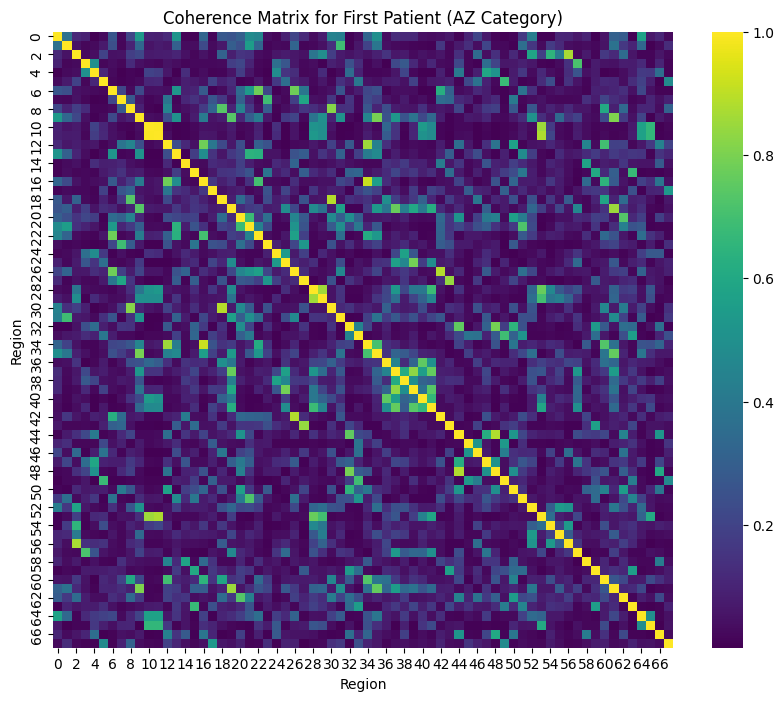

In [ ]:
# Function to visualize a single coherence matrix
def visualize_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel('Region')
    plt.ylabel('Region')
    plt.show()

# Extract the coherence matrix for the first patient in the AZ category
single_patient_az_matrix = coherence_AZ_rebuilt[:, :, 0, 0]  # Choosing the first frequency band (index 0)

# Visualize the coherence matrix for the first patient in the AZ category
visualize_matrix(single_patient_az_matrix, 'Coherence Matrix for First Patient (AZ Category)')

Extracts edge features from the coherence matrices and assigns labels to them. The function iterates over the subjects and bands, extracting the upper triangular part of each coherence matrix (excluding the diagonal). These edge attributes are then stored in a feature array, and the corresponding labels are stored in a label array




In [ ]:

# Extract edge features and labels
def extract_edge_features_labels(data, label):
    features = []
    labels = []
    for i in range(data.shape[3]):
        for j in range(data.shape[2]):
            matrix = data[:, :, j, i]
            edge_attr = matrix[np.triu_indices_from(matrix, k=1)]
            features.append(edge_attr)
            labels.append(label)
    return np.array(features), np.array(labels)

Use the `extract_edge_features_labels` function to extract features and labels for AZ vs FTD classification


In [ ]:
# Extract features and labels for AZ vs FTD
features_az_hc, labels_az_hc = extract_edge_features_labels(coherence_HC_rebuilt, 1)
features_az_hc_, labels_az_hc_ = extract_edge_features_labels(coherence_AZ_rebuilt, 0)
features_az_hc = np.concatenate((features_az_hc, features_az_hc_), axis=0)
labels_az_hc = np.concatenate((labels_az_hc, labels_az_hc_), axis=0)

Split the extracted features and labels into training and testing sets for AZ vs FTD classification


In [ ]:
# Split data into training and testing sets for AZ vs HC
X_train_az_hc, X_test_az_hc, y_train_az_hc, y_test_az_hc = train_test_split(features_az_hc, labels_az_hc, test_size=0.2, random_state=38)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna

# Hyperparameter tuning using Optuna for GaussianNB (AZ vs HC)
def objective_gaussian_nb(trial):
    # GaussianNB does not have hyperparameters to tune via Optuna

    gaussian_nb = GaussianNB()
    scores = cross_val_score(gaussian_nb, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

study_gaussian_nb_az_hc = optuna.create_study(direction='maximize')
study_gaussian_nb_az_hc.optimize(objective_gaussian_nb, n_trials=1)  # No real hyperparameters to optimize

best_params_gaussian_nb_az_hc = study_gaussian_nb_az_hc.best_params
best_cv_score = study_gaussian_nb_az_hc.best_value
print("Best parameters for GaussianNB (AZ vs HC):", best_params_gaussian_nb_az_hc)
print("Best cross-validation score for GaussianNB (AZ vs HC):", best_cv_score)

gaussian_nb_az_hc = GaussianNB()
gaussian_nb_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = gaussian_nb_az_hc.predict(X_test_az_hc)
print("Classification Report for GaussianNB (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for GaussianNB (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for GaussianNB (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 06:49:31,170] A new study created in memory with name: no-name-adf39d00-233b-46f1-9ac8-784a55b07485
[I 2024-08-07 06:49:31,210] Trial 0 finished with value: 0.8099999999999999 and parameters: {}. Best is trial 0 with value: 0.8099999999999999.


Best parameters for GaussianNB (AZ vs HC): {}
Best cross-validation score for GaussianNB (AZ vs HC): 0.8099999999999999
Classification Report for GaussianNB (AZ vs HC):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.88      0.93         8

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13

Confusion Matrix for GaussianNB (AZ vs HC):
[[5 0]
 [1 7]]
Accuracy for GaussianNB (AZ vs HC): 0.9230769230769231


In [ ]:
import optuna
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hyperparameter tuning using Optuna for BaggingClassifier (AZ vs HC)
def objective_bagging(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    bootstrap_features = trial.suggest_categorical('bootstrap_features', [True, False])

    bagging = BaggingClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        bootstrap=bootstrap,
        bootstrap_features=bootstrap_features
    )

    scores = cross_val_score(bagging, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

study_bagging = optuna.create_study(direction='maximize')
study_bagging.optimize(objective_bagging, n_trials=30)

best_params_bagging = study_bagging.best_params
best_cv_score = study_bagging.best_value
print("Best parameters for BaggingClassifier (AZ vs HC):", best_params_bagging)
print("Best cross-validation score for BaggingClassifier (AZ vs HC):", best_cv_score)

bagging = BaggingClassifier(**best_params_bagging)
bagging.fit(X_train_az_hc, y_train_az_hc)
y_pred_bagging = bagging.predict(X_test_az_hc)
print("Classification Report for BaggingClassifier (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_bagging))
print("Confusion Matrix for BaggingClassifier (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_bagging))
print("Accuracy for BaggingClassifier (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_bagging))


[I 2024-07-26 06:45:37,205] A new study created in memory with name: no-name-93fb0d59-a8de-45e3-ad29-5be20d4ff1eb
[I 2024-07-26 06:45:50,820] Trial 0 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 143, 'max_samples': 0.4175715202194049, 'max_features': 0.7183604352449297, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-07-26 06:45:52,544] Trial 1 finished with value: 0.6533333333333333 and parameters: {'n_estimators': 53, 'max_samples': 0.12315562376463077, 'max_features': 0.9059795088760364, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-07-26 06:46:01,266] Trial 2 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 127, 'max_samples': 0.46865558456165013, 'max_features': 0.6723216384520057, 'bootstrap': True, 'bootstrap_features': True}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-07-26 06:46:04,499] Trial 3 fin

Best parameters for BaggingClassifier (AZ vs HC): {'n_estimators': 56, 'max_samples': 0.26754534376588807, 'max_features': 0.10422935731562243, 'bootstrap': True, 'bootstrap_features': True}
Best cross-validation score for BaggingClassifier (AZ vs HC): 0.8533333333333335
Classification Report for BaggingClassifier (AZ vs HC):
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.83      1.00      0.91         5

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13

Confusion Matrix for BaggingClassifier (AZ vs HC):
[[7 1]
 [0 5]]
Accuracy for BaggingClassifier (AZ vs HC): 0.9230769230769231


In [ ]:
# Hyperparameter tuning using Optuna for ExtraTreesClassifier (AZ vs HC)
def objective_extra_trees(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    extra_trees = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features, random_state=42)
    # extra_trees.fit(X_train_az_hc, y_train_az_hc)
    # y_pred = extra_trees.predict(X_test_az_hc)
    # return accuracy_score(y_test_az_hc, y_pred)
    scores = cross_val_score(extra_trees, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()


study_extra_trees_az_hc = optuna.create_study(direction='maximize')
study_extra_trees_az_hc.optimize(objective_extra_trees, n_trials=30)

best_params_extra_trees_az_hc = study_extra_trees_az_hc.best_params
print("Best parameters for ExtraTreesClassifier (AZ vs HC):", best_params_extra_trees_az_hc)

extra_trees_az_hc = ExtraTreesClassifier(**best_params_extra_trees_az_hc, random_state=42)
extra_trees_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = extra_trees_az_hc.predict(X_test_az_hc)
print("Classification Report for ExtraTreesClassifier (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for ExtraTreesClassifier (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for ExtraTreesClassifier (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))

[I 2024-07-22 08:32:45,100] A new study created in memory with name: no-name-2900fa43-5447-4033-a9cc-5d2ee804cd8e
[I 2024-07-22 08:32:47,495] Trial 0 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 192, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-07-22 08:32:48,895] Trial 1 finished with value: 0.7766666666666666 and parameters: {'n_estimators': 27, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-07-22 08:32:49,891] Trial 2 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-07-22 08:32:52,251] Trial 3 finished with value: 0.7899999999999999 and parameters: {'n_estimators': 120, 'max_depth': 6, 'min_s

Best parameters for ExtraTreesClassifier (AZ vs HC): {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}
Classification Report for ExtraTreesClassifier (AZ vs HC):
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.83      1.00      0.91         5

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13

Confusion Matrix for ExtraTreesClassifier (AZ vs HC):
[[7 1]
 [0 5]]
Accuracy for ExtraTreesClassifier (AZ vs HC): 0.9230769230769231


In [ ]:
# Hyperparameter tuning using Optuna for SVC (FTD vs HC)
def objective_svc_az_hc(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    svc = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    # svc.fit(X_train_az_hc, y_train_az_hc)

    scores = cross_val_score(svc, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

    # y_pred = svc.predict(X_test_az_hc)
    # return accuracy_score(y_test_az_hc, y_pred)

study_svc_az_hc = optuna.create_study(direction='maximize')
study_svc_az_hc.optimize(objective_svc_az_hc, n_trials=50)

best_params_svc_az_hc = study_svc_az_hc.best_params
print("Best parameters for SVC (AZ vs HC):", best_params_svc_az_hc)

svc_az_hc = SVC(**best_params_svc_az_hc, probability=True)
svc_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = svc_az_hc.predict(X_test_az_hc)
print("Classification Report for SVC (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for SVC (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for SVC (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))

[I 2024-07-22 08:36:19,761] A new study created in memory with name: no-name-bdcd7e1d-9ee4-4ddf-aade-497f7d443615
<ipython-input-16-3619785db9d8>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
<ipython-input-16-3619785db9d8>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-07-22 08:36:20,335] Trial 0 finished with value: 0.5333333333333333 and parameters: {'C': 0.05081211886536171, 'gamma': 0.028722863805973414, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5333333333333333.
<ipython-input-16-3619785db9d8>:3: FutureWarning: suggest_loguniform has been deprecated

Best parameters for SVC (AZ vs HC): {'C': 2.1214906873874253, 'gamma': 0.004484292508881285, 'kernel': 'rbf'}
Classification Report for SVC (AZ vs HC):
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.83      1.00      0.91         5

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13

Confusion Matrix for SVC (AZ vs HC):
[[7 1]
 [0 5]]
Accuracy for SVC (AZ vs HC): 0.9230769230769231


In [ ]:
import optuna
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for BernoulliNB (FTD vs HC)
def objective_bernoulli_nb_az_hc(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e0)
    binarize = trial.suggest_loguniform('binarize', 1e-3, 1e0)

    bernoulli_nb = BernoulliNB(alpha=alpha, binarize=binarize)
    # bernoulli_nb.fit(X_train_az_hc, y_train_az_hc)

    scores = cross_val_score(bernoulli_nb, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

    # y_pred = bernoulli_nb.predict(X_test_az_hc)
    # return accuracy_score(y_test_az_hc, y_pred)

study_bernoulli_nb_az_hc = optuna.create_study(direction='maximize')
study_bernoulli_nb_az_hc.optimize(objective_bernoulli_nb_az_hc, n_trials=50)

best_params_bernoulli_nb_az_hc = study_bernoulli_nb_az_hc.best_params
print("Best parameters for BernoulliNB (AZ vs HC):", best_params_bernoulli_nb_az_hc)

bernoulli_nb_az_hc = BernoulliNB(**best_params_bernoulli_nb_az_hc)
bernoulli_nb_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = bernoulli_nb_az_hc.predict(X_test_az_hc)
print("Classification Report for BernoulliNB (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for BernoulliNB (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for BernoulliNB (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 07:00:41,012] A new study created in memory with name: no-name-2be4f9d8-3cec-4902-af29-9408d547516a
<ipython-input-17-f9f43ef7056b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-3, 1e0)
<ipython-input-17-f9f43ef7056b>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binarize = trial.suggest_loguniform('binarize', 1e-3, 1e0)
[I 2024-08-07 07:00:41,113] Trial 0 finished with value: 0.75 and parameters: {'alpha': 0.0022744606269213506, 'binarize': 0.029188075114662138}. Best is trial 0 with value: 0.75.
<ipython-input-17-f9f43ef7056b>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featu

Best parameters for BernoulliNB (AZ vs HC): {'alpha': 0.002591510700160253, 'binarize': 0.41988659906352094}
Classification Report for BernoulliNB (AZ vs HC):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13

Confusion Matrix for BernoulliNB (AZ vs HC):
[[5 0]
 [2 6]]
Accuracy for BernoulliNB (AZ vs HC): 0.8461538461538461


In [ ]:
import optuna
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_az_hc_std = scaler.fit_transform(X_train_az_hc)
X_test_az_hc_std = scaler.transform(X_test_az_hc)

# Hyperparameter tuning using Optuna for LinearDiscriminantAnalysis (AZ vs HC)
def objective_lda_az_hc(trial):
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    shrinkage = None
    if solver in ['lsqr', 'eigen']:
        shrinkage = trial.suggest_categorical('shrinkage', [None, 'auto', 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)

    try:
        scores = cross_val_score(lda, X_train_az_hc_std, y_train_az_hc, cv=10, error_score='raise')
        return scores.mean()
    except np.linalg.LinAlgError:
        return float('nan')

study_lda_az_hc = optuna.create_study(direction='maximize')
study_lda_az_hc.optimize(objective_lda_az_hc, n_trials=25)

best_params_lda_az_hc = study_lda_az_hc.best_params
print("Best parameters for LinearDiscriminantAnalysis (AZ vs HC):", best_params_lda_az_hc)

solver = best_params_lda_az_hc['solver']
shrinkage = best_params_lda_az_hc.get('shrinkage', None)

lda_az_hc = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
lda_az_hc.fit(X_train_az_hc_std, y_train_az_hc)
y_pred_az_hc = lda_az_hc.predict(X_test_az_hc_std)

print("Classification Report for LinearDiscriminantAnalysis (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for LinearDiscriminantAnalysis (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for LinearDiscriminantAnalysis (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 07:53:37,408] A new study created in memory with name: no-name-c6f154ea-4767-4cef-9702-39669c8f772c
[I 2024-08-07 07:53:37,836] Trial 0 finished with value: 0.7833333333333333 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.7833333333333333.
[I 2024-08-07 07:53:38,255] Trial 1 finished with value: 0.7833333333333333 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.7833333333333333.
[I 2024-08-07 07:54:45,776] Trial 2 finished with value: 0.8266666666666668 and parameters: {'solver': 'eigen', 'shrinkage': 0.7}. Best is trial 2 with value: 0.8266666666666668.
[I 2024-08-07 07:55:59,978] Trial 3 finished with value: 0.8266666666666668 and parameters: {'solver': 'lsqr', 'shrinkage': 0.6}. Best is trial 2 with value: 0.8266666666666668.
[I 2024-08-07 07:56:54,787] Trial 4 finished with value: 0.8266666666666668 and parameters: {'solver': 'eigen', 'shrinkage': 0.1}. Best is trial 2 with value: 0.8266666666666668.
[I 2024-08-07 07:57:45,559] Tria

Best parameters for LinearDiscriminantAnalysis (AZ vs HC): {'solver': 'eigen', 'shrinkage': 0.9}
Classification Report for LinearDiscriminantAnalysis (AZ vs HC):
              precision    recall  f1-score   support

           0       0.33      0.60      0.43         5
           1       0.50      0.25      0.33         8

    accuracy                           0.38        13
   macro avg       0.42      0.42      0.38        13
weighted avg       0.44      0.38      0.37        13

Confusion Matrix for LinearDiscriminantAnalysis (AZ vs HC):
[[3 2]
 [6 2]]
Accuracy for LinearDiscriminantAnalysis (AZ vs HC): 0.38461538461538464


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for RandomForestClassifier (FTD vs HC)
def objective_rf_az_hc(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    scores = cross_val_score(rf, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

study_rf_az_hc = optuna.create_study(direction='maximize')
study_rf_az_hc.optimize(objective_rf_az_hc, n_trials=50)

best_params_rf_az_hc = study_rf_az_hc.best_params
print("Best parameters for RandomForestClassifier (AZ vs HC):", best_params_rf_az_hc)

rf_az_hc = RandomForestClassifier(**best_params_rf_az_hc, random_state=42)
rf_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = rf_az_hc.predict(X_test_az_hc)

print("Classification Report for RandomForestClassifier (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for RandomForestClassifier (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for RandomForestClassifier (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 07:10:01,217] A new study created in memory with name: no-name-4f3e981b-4452-43ef-a34d-5bef8cb984c6
[I 2024-08-07 07:10:05,470] Trial 0 finished with value: 0.79 and parameters: {'n_estimators': 207, 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.79.
[I 2024-08-07 07:10:06,368] Trial 1 finished with value: 0.7666666666666666 and parameters: {'n_estimators': 54, 'max_depth': 25, 'min_samples_split': 19, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.79.
[I 2024-08-07 07:10:10,312] Trial 2 finished with value: 0.5966666666666665 and parameters: {'n_estimators': 285, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.79.
[I 2024-08-07 07:10:12,537] Trial 3 finished with value: 0.5966666666666665 and parameters: {'n_estimators': 162, 'max_depth': 26, 'min_samples_split': 17, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.79.
[I 2024-08-07 07:10:18,380] Trial 4 finished 

Best parameters for RandomForestClassifier (AZ vs HC): {'n_estimators': 127, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}
Classification Report for RandomForestClassifier (AZ vs HC):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13

Confusion Matrix for RandomForestClassifier (AZ vs HC):
[[5 0]
 [2 6]]
Accuracy for RandomForestClassifier (AZ vs HC): 0.8461538461538461


In [ ]:
import optuna
from sklearn.svm import NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Hyperparameter tuning using Optuna for NuSVC (AZ vs HC)
def objective_nusvc_az_hc(trial):
    nu = trial.suggest_uniform('nu', 0.1, 0.9)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    nusvc = NuSVC(nu=nu, gamma=gamma, kernel=kernel, probability=True)

    try:
        scores = cross_val_score(nusvc, X_train_az_hc, y_train_az_hc, cv=10)
        return scores.mean()
    except ValueError as e:
        # If the combination is not feasible, return a very low score
        return 0.0

study_nusvc_az_hc = optuna.create_study(direction='maximize')
study_nusvc_az_hc.optimize(objective_nusvc_az_hc, n_trials=50)

best_params_nusvc_az_hc = study_nusvc_az_hc.best_params
print("Best parameters for NuSVC (AZ vs HC):", best_params_nusvc_az_hc)

nusvc_az_hc = NuSVC(**best_params_nusvc_az_hc, probability=True)
nusvc_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = nusvc_az_hc.predict(X_test_az_hc)

print("Classification Report for NuSVC (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for NuSVC (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for NuSVC (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 07:41:53,805] A new study created in memory with name: no-name-416517b3-519f-4fd0-a6b7-835decb27709
<ipython-input-24-73145192cb45>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nu = trial.suggest_uniform('nu', 0.1, 0.9)  # Narrowed range to avoid infeasible nu
<ipython-input-24-73145192cb45>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-08-07 07:41:53,915] Trial 0 finished with value: 0.75 and parameters: {'nu': 0.6927341058036091, 'gamma': 0.014089448001678172, 'kernel': 'poly'}. Best is trial 0 with value: 0.75.
<ipython-input-24-73145192cb45>:9: FutureWarning: suggest_uniform has been deprecated in v3.0

Best parameters for NuSVC (AZ vs HC): {'nu': 0.6685905029509547, 'gamma': 0.00016218061489856568, 'kernel': 'linear'}
Classification Report for NuSVC (AZ vs HC):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.88      0.93         8

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13

Confusion Matrix for NuSVC (AZ vs HC):
[[5 0]
 [1 7]]
Accuracy for NuSVC (AZ vs HC): 0.9230769230769231


In [ ]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning using Optuna for AdaBoostClassifier (AZ vs HC)
def objective_adaboost_az_hc(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e0)

    adaboost = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    scores = cross_val_score(adaboost, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

study_adaboost_az_hc = optuna.create_study(direction='maximize')
study_adaboost_az_hc.optimize(objective_adaboost_az_hc, n_trials=25)

best_params_adaboost_az_hc = study_adaboost_az_hc.best_params
print("Best parameters for AdaBoostClassifier (AZ vs HC):", best_params_adaboost_az_hc)

adaboost_az_hc = AdaBoostClassifier(**best_params_adaboost_az_hc, random_state=42)
adaboost_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = adaboost_az_hc.predict(X_test_az_hc)

print("Classification Report for AdaBoostClassifier (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for AdaBoostClassifier (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for AdaBoostClassifier (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 07:16:17,607] A new study created in memory with name: no-name-4ebbbb21-7146-4436-b3a2-63daf99e6b01
<ipython-input-23-9566500c591a>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e0)
[I 2024-08-07 07:16:37,671] Trial 0 finished with value: 0.7899999999999999 and parameters: {'n_estimators': 97, 'learning_rate': 0.7013722925835014}. Best is trial 0 with value: 0.7899999999999999.
<ipython-input-23-9566500c591a>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e0)
[I 2024-08-07 07:17:07,298] Trial 1 finished with value: 0.75 and

Best parameters for AdaBoostClassifier (AZ vs HC): {'n_estimators': 319, 'learning_rate': 0.004207821725861507}
Classification Report for AdaBoostClassifier (AZ vs HC):
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.83      0.62      0.71         8

    accuracy                           0.69        13
   macro avg       0.70      0.71      0.69        13
weighted avg       0.73      0.69      0.70        13

Confusion Matrix for AdaBoostClassifier (AZ vs HC):
[[4 1]
 [3 5]]
Accuracy for AdaBoostClassifier (AZ vs HC): 0.6923076923076923


In [ ]:
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning using Optuna for LogisticRegression (AZ vs HC)
def objective_logreg_az_hc(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    logreg = LogisticRegression(C=C, solver=solver, random_state=42)
    scores = cross_val_score(logreg, X_train_az_hc, y_train_az_hc, cv=10)
    return scores.mean()

study_logreg_az_hc = optuna.create_study(direction='maximize')
study_logreg_az_hc.optimize(objective_logreg_az_hc, n_trials=50)

best_params_logreg_az_hc = study_logreg_az_hc.best_params
print("Best parameters for LogisticRegression (AZ vs HC):", best_params_logreg_az_hc)

logreg_az_hc = LogisticRegression(**best_params_logreg_az_hc, random_state=42)
logreg_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = logreg_az_hc.predict(X_test_az_hc)
print("Classification Report for LogisticRegression (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print("Confusion Matrix for LogisticRegression (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print("Accuracy for LogisticRegression (AZ vs HC):", accuracy_score(y_test_az_hc, y_pred_az_hc))


[I 2024-08-07 07:49:09,110] A new study created in memory with name: no-name-05d6c0f0-f68e-4016-924a-84102ec15074
<ipython-input-27-322d972dec18>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2024-08-07 07:49:09,222] Trial 0 finished with value: 0.6166666666666666 and parameters: {'C': 0.008537993285283839, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6166666666666666.
<ipython-input-27-322d972dec18>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

Best parameters for LogisticRegression (AZ vs HC): {'C': 0.07082735890226205, 'solver': 'liblinear'}
Classification Report for LogisticRegression (AZ vs HC):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13

Confusion Matrix for LogisticRegression (AZ vs HC):
[[5 0]
 [2 6]]
Accuracy for LogisticRegression (AZ vs HC): 0.8461538461538461


In [ ]:
# Import necessary libraries for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Define the classifiers with the best parameters
classifiers = {
    'GaussianNB': GaussianNB(),  # GaussianNB does not have hyperparameters to tune

    'ExtraTreesClassifier': ExtraTreesClassifier(
        n_estimators=160,
        max_depth=10,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features=None,
        random_state=42
    ),

    'SVC': SVC(
        C=2.1214906873874253,
        gamma=0.004484292508881285,
        kernel='rbf',
        probability=True
    ),

    'BaggingClassifier': BaggingClassifier(
        n_estimators=56,
        max_samples=0.26754534376588807,
        max_features=0.10422935731562243,
        bootstrap=True,
        bootstrap_features=True,
        random_state=42
    ),

    'BernoulliNB': BernoulliNB(
        alpha=0.002591510700160253,
        binarize=0.41988659906352094
    ),

    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(
        solver='eigen',
        shrinkage=0.9
    ),

    'RandomForestClassifier': RandomForestClassifier(
        n_estimators=127,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42
    ),

    'NuSVC': NuSVC(
        nu=0.6685905029509547,
        gamma=0.00016218061489856568,
        kernel='linear',
        probability=True
    ),

    'AdaBoostClassifier': AdaBoostClassifier(
        n_estimators=319,
        learning_rate=0.004207821725861507,
        random_state=42
    ),

    'LogisticRegression': LogisticRegression(
        C=0.07082735890226205,
        solver='liblinear',
        random_state=42
    )
}

# Perform cross-validation and store the results
cv_results = {}

for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_az_hc, y_train_az_hc, cv=10)
    cv_results[name] = scores
    # Uncomment the following line to print detailed cross-validation results
    # print(f"{name} cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Print summary of cross-validation results
print("\nSummary of cross-validation results:")
for name, scores in cv_results.items():
    print(f"{name}: Mean accuracy = {scores.mean():.4f}, Standard deviation = {scores.std():.4f}")

# Choose the best model based on mean cross-validation accuracy
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print(f"\nBest model based on cross-validation: {best_model_name}")

# Evaluate the best model on the test set for AZ vs HC
best_model_az_hc = classifiers[best_model_name]
best_model_az_hc.fit(X_train_az_hc, y_train_az_hc)
y_pred_az_hc = best_model_az_hc.predict(X_test_az_hc)

print(f"\nClassification Report for {best_model_name} (AZ vs HC):")
print(classification_report(y_test_az_hc, y_pred_az_hc))
print(f"Confusion Matrix for {best_model_name} (AZ vs HC):")
print(confusion_matrix(y_test_az_hc, y_pred_az_hc))
print(f"Accuracy for {best_model_name} (AZ vs HC): {accuracy_score(y_test_az_hc, y_pred_az_hc):.4f}")



Summary of cross-validation results:
GaussianNB: Mean accuracy = 0.8167, Standard deviation = 0.1833
ExtraTreesClassifier: Mean accuracy = 0.8500, Standard deviation = 0.1746
SVC: Mean accuracy = 0.8733, Standard deviation = 0.1541
BaggingClassifier: Mean accuracy = 0.7367, Standard deviation = 0.1946
BernoulliNB: Mean accuracy = 0.8733, Standard deviation = 0.1541
LinearDiscriminantAnalysis: Mean accuracy = 0.8033, Standard deviation = 0.1552
RandomForestClassifier: Mean accuracy = 0.8700, Standard deviation = 0.1552
NuSVC: Mean accuracy = 0.8567, Standard deviation = 0.1967
AdaBoostClassifier: Mean accuracy = 0.7333, Standard deviation = 0.1229
LogisticRegression: Mean accuracy = 0.8367, Standard deviation = 0.1912

Best model based on cross-validation: SVC

Classification Report for SVC (AZ vs HC):
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.67      0.80         9

    accuracy          

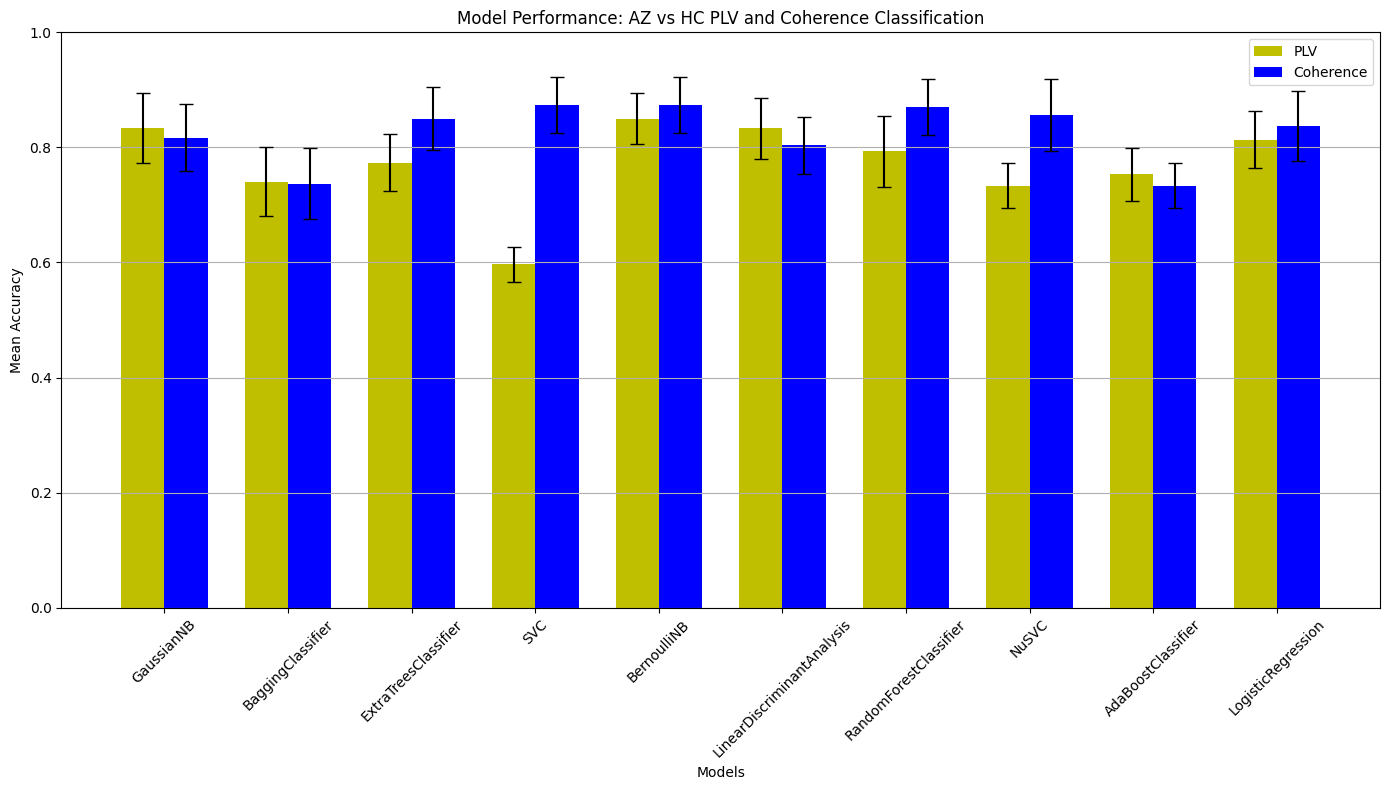

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ordered models
models = ['GaussianNB', 'BaggingClassifier', 'ExtraTreesClassifier', 'SVC', 'BernoulliNB',
          'LinearDiscriminantAnalysis', 'RandomForestClassifier', 'NuSVC', 'AdaBoostClassifier', 'LogisticRegression']

# Data for AZ vs HC PLV classification
mean_acc_plv = [0.8333, 0.7400, 0.7733, 0.5967, 0.8500, 0.8333, 0.7933, 0.7333, 0.7533, 0.8133]
std_dev_plv = [0.1915, 0.1896, 0.1562, 0.0971, 0.1392, 0.1673, 0.1943, 0.1229, 0.1462, 0.1579]

# Data for AZ vs HC Coherence classification
mean_acc_coherence = [0.8167, 0.7367, 0.8500, 0.8733, 0.8733, 0.8033, 0.8700, 0.8567, 0.7333, 0.8367]
std_dev_coherence = [0.1833, 0.1946, 0.1746, 0.1541, 0.1541, 0.1552, 0.1552, 0.1967, 0.1229, 0.1912]

# Calculate standard error
n = 10
std_err_plv = [std / np.sqrt(n) for std in std_dev_plv]
std_err_coherence = [std / np.sqrt(n) for std in std_dev_coherence]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(models))

# Bar plots
bars_plv = ax.bar(index - bar_width/2, mean_acc_plv, bar_width, yerr=std_err_plv, capsize=5, label='PLV', color='y')
bars_coherence = ax.bar(index + bar_width/2, mean_acc_coherence, bar_width, yerr=std_err_coherence, capsize=5, label='Coherence', color='b')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Model Performance: AZ vs HC PLV and Coherence Classification')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend()

ax.set_ylim(0, 1)
# Add grid
ax.yaxis.grid(True)

# Show plot
plt.tight_layout()
plt.show()
